# Parson's Figure Recreation Using CMIP6 Data

In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs

## Loading in data

In [2]:
cat = pd.read_csv('/data/keeling/a/cristi/a/esm_data/cmip6_catalog.csv')
cat

activity_id branch_method branch_time_in_child branch_time_in_parent  \
0             CMIP      standard                  0.0                   0.0   
1             CMIP      standard                  0.0                   0.0   
2             CMIP      standard                  0.0                   0.0   
3             CMIP      standard                  0.0                   0.0   
4             CMIP      standard                  0.0                   0.0   
...            ...           ...                  ...                   ...   
11429  ScenarioMIP      standard              59400.0               59400.0   
11430  ScenarioMIP      standard              59400.0               59400.0   
11431  ScenarioMIP      standard              59400.0               59400.0   
11432  ScenarioMIP      standard              59400.0               59400.0   
11433  ScenarioMIP      standard              59400.0               59400.0   

                           experiment experiment_id frequency  \
0           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
1           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
2           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
3           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
4           abrupt quadrupling of CO2  abrupt-4xCO2       mon   
...                               ...           ...       ...   
11429  update of RCP8.5 based on SSP5        ssp585       mon   
11430  update of RCP8.5 based on SSP5        ssp585       mon   
11431  update of RCP8.5 based on SSP5        ssp585       mon   
11432  update of RCP8.5 based on SSP5        ssp585       mon   
11433  update of RCP8.5 based on SSP5        ssp585       mon   

                                                grid grid_label  \
0       native atmosphere N96 grid (144x192 latxlon)         gn   
1       native atmosphere N96 grid (144x192 latxlon)         gn   
2       native atmosphere N96 grid (144x192 latxlon)         gn   
3       native atmosphere N96 grid (144x192 latxlon)         gn   
4       native atmosphere N96 grid (144x192 latxlon)         gn   
...                                              ...        ...   
11429  Native N96 grid; 192 x 144 longitude/latitude         gn   
11430  Native N96 grid; 192 x 144 longitude/latitude         gn   
11431  Native N96 grid; 192 x 144 longitude/latitude         gn   
11432  Native N96 grid; 192 x 144 longitude/latitude         gn   
11433  Native N96 grid; 192 x 144 longitude/latitude         gn   

      institution_id  ...                              standard_name  \
0       CSIRO-ARCCSS  ...            surface_upward_latent_heat_flux   
1       CSIRO-ARCCSS  ...          surface_upward_sensible_heat_flux   
2       CSIRO-ARCCSS  ...   surface_downwelling_longwave_flux_in_air   
3       CSIRO-ARCCSS  ...     surface_upwelling_longwave_flux_in_air   
4       CSIRO-ARCCSS  ...                 toa_outgoing_longwave_flux   
...              ...  ...                                        ...   
11429           MOHC  ...  surface_downwelling_shortwave_flux_in_air   
11430           MOHC  ...                toa_incoming_shortwave_flux   
11431           MOHC  ...    surface_upwelling_shortwave_flux_in_air   
11432           MOHC  ...                toa_outgoing_shortwave_flux   
11433           MOHC  ...                            air_temperature   

                                     long_name  units vertical_levels  \
0              Surface Upward Latent Heat Flux  W m-2             1.0   
1            Surface Upward Sensible Heat Flux  W m-2             1.0   
2       Surface Downwelling Longwave Radiation  W m-2             1.0   
3         Surface Upwelling Longwave Radiation  W m-2             1.0   
4              TOA Outgoing Longwave Radiation  W m-2             1.0   
...                                        ...    ...             ...   
11429  Surface Downwelling Shortwave Radiation  W m-2             1.0   
11430         TOA Incid

## Control Data

In [3]:
path = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('Control'))].drop_duplicates('source_id').head(38)['path'].to_list()
path

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/tas_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/tas_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/tas_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/tas_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_195301-193912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/tas_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/tas_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/tas_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/t

In [4]:
path.remove('/data/cristi/a/cristi/esm_data/cmip6/IITM-ESM/piControl/r1i1p1f1/tas_Amon_IITM-ESM_piControl_r1i1p1f1_gn_192601-193512.nc')
print(path)
print(len(path))

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/piControl/r1i1p1f1/tas_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc', '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/piControl/r1i1p1f1/tas_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/piControl/r1i1p1f1/tas_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc', '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/piControl/r1i1p1f1/tas_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_195301-193912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/piControl/r1i1p1f1/tas_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc', '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/piControl/r1i1p1f1/tas_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/piControl/r1i1p1f1/tas_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc', '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/piControl/r1i1p1f1/tas_Amon

In [5]:
ds_one = xr.open_dataset(path[36])
ds_one

<xarray.Dataset>
Dimensions:   (lat: 120, bnds: 2, lon: 180, time: 14412)
Coordinates:
    height    float64 ...
  * lat       (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
    lat_bnds  (lat, bnds) float64 ...
  * lon       (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    lon_bnds  (lon, bnds) float64 ...
  * time      (time) object 1996-01-16 12:00:00 ... 3196-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    tas       (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_id:               Amon
    table_info:             Creation Date:(20 February 2019) MD5:951084b632bd...
    title:                  INM-CM5-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/6aff1e77-a372-419c-b378-fa1fed6c16c3...
    variable_id:            tas
    variant_label:          r1i1p1f1

In [6]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_control = []

for file in path:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_tas_rolling = ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_tas = ds_tas_rolling.std('time')
    ds_tas['name'] = name # Creating a new dimension for each ensemble member
    dset_list_control.append(ds_tas)

ACCESS-CM2/piControl/r1i1p1f1/tas_Amon_ACCESS-CM2_piControl_r1i1p1f1_gn_095001-144912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


ACCESS-ESM1-5/piControl/r1i1p1f1/tas_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

AWI-CM-1-1-MR/piControl/r1i1p1f1/tas_Amon_AWI-CM-1-1-MR_piControl_r1i1p1f1_gn_240101-290012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


AWI-ESM-1-1-LR/piControl/r1i1p1f1/tas_Amon_AWI-ESM-1-1-LR_piControl_r1i1p1f1_gn_195301-193912.nc
BCC-CSM2-MR/piControl/r1i1p1f1/tas_Amon_BCC-CSM2-MR_piControl_r1i1p1f1_gn_185001-244912.nc
BCC-ESM1/piControl/r1i1p1f1/tas_Amon_BCC-ESM1_piControl_r1i1p1f1_gn_185001-230012.nc
CAMS-CSM1-0/piControl/r1i1p1f1/tas_Amon_CAMS-CSM1-0_piControl_r1i1p1f1_gn_290001-339912.nc
CAS-ESM2-0/piControl/r1i1p1f1/tas_Amon_CAS-ESM2-0_piControl_r1i1p1f1_gn_000101-054912.nc
CESM2-FV2/piControl/r1i1p1f1/tas_Amon_CESM2-FV2_piControl_r1i1p1f1_gn_000101-005012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM-FV2/piControl/r1i1p1f1/tas_Amon_CESM2-WACCM-FV2_piControl_r1i1p1f1_gn_000101-004912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2-WACCM/piControl/r1i1p1f1/tas_Amon_CESM2-WACCM_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CESM2/piControl/r1i1p1f1/tas_Amon_CESM2_piControl_r1i1p1f1_gn_000101-009912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


CIESM/piControl/r1i1p1f1/tas_Amon_CIESM_piControl_r1i1p1f1_gr_000101-005012.nc
CMCC-CM2-SR5/piControl/r1i1p1f1/tas_Amon_CMCC-CM2-SR5_piControl_r1i1p1f1_gn_185001-209912.nc
CNRM-CM6-1-HR/piControl/r1i1p1f2/tas_Amon_CNRM-CM6-1-HR_piControl_r1i1p1f2_gr_185001-214912.nc
CNRM-CM6-1/piControl/r1i1p1f2/tas_Amon_CNRM-CM6-1_piControl_r1i1p1f2_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


CNRM-ESM2-1/piControl/r1i1p1f2/tas_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc
CanESM5-CanOE/piControl/r1i1p2f1/tas_Amon_CanESM5-CanOE_piControl_r1i1p2f1_gn_555001-605012.nc
CanESM5/piControl/r1i1p1f1/tas_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc
E3SM-1-0/piControl/r1i1p1f1/tas_Amon_E3SM-1-0_piControl_r1i1p1f1_gr_000101-002512.nc
E3SM-1-1-ECA/piControl/r1i1p1f1/tas_Amon_E3SM-1-1-ECA_piControl_r1i1p1f1_gr_185001-201412.nc
E3SM-1-1/piControl/r1i1p1f1/tas_Amon_E3SM-1-1_piControl_r1i1p1f1_gr_185001-201412.nc
EC-Earth3-AerChem/piControl/r1i1p1f1/tas_Amon_EC-Earth3-AerChem_piControl_r1i1p1f1_gr_185001-216012.nc
EC-Earth3-Veg-LR/piControl/r1i1p1f1/tas_Amon_EC-Earth3-Veg-LR_piControl_r1i1p1f1_gr_230001-280012.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


EC-Earth3-Veg/piControl/r1i1p1f1/tas_Amon_EC-Earth3-Veg_piControl_r1i1p1f1_gr_185001-234912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


EC-Earth3/piControl/r1i1p1f1/tas_Amon_EC-Earth3_piControl_r1i1p1f1_gr_225901-275912.nc


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


FGOALS-f3-L/piControl/r1i1p1f1/tas_Amon_FGOALS-f3-L_piControl_r1i1p1f1_gr_060001-116012.nc
FGOALS-g3/piControl/r1i1p1f1/tas_Amon_FGOALS-g3_piControl_r1i1p1f1_gn_020001-089912.nc
FIO-ESM-2-0/piControl/r1i1p1f1/tas_Amon_FIO-ESM-2-0_piControl_r1i1p1f1_gn_030101-087512.nc
GISS-E2-1-G-CC/piControl/r1i1p1f1/tas_Amon_GISS-E2-1-G-CC_piControl_r1i1p1f1_gn_185001-201412.nc
GISS-E2-1-G/piControl/r101i1p1f1/tas_Amon_GISS-E2-1-G_piControl_r101i1p1f1_gn_185001-201412.nc
GISS-E2-1-H/piControl/r1i1p1f1/tas_Amon_GISS-E2-1-H_piControl_r1i1p1f1_gn_318001-323012.nc
GISS-E2-2-G/piControl/r1i1p1f1/tas_Amon_GISS-E2-2-G_piControl_r1i1p1f1_gn_200001-202512.nc
HadGEM3-GC31-LL/piControl/r1i1p1f1/tas_Amon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_185001-234912.nc
HadGEM3-GC31-MM/piControl/r1i1p1f1/tas_Amon_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn_185001-234912.nc
INM-CM4-8/piControl/r1i1p1f1/tas_Amon_INM-CM4-8_piControl_r1i1p1f1_gr1_185001-238012.nc
INM-CM5-0/piControl/r1i1p1f1/tas_Amon_INM-CM5-0_piControl_r1i1p1f1_gr1_

In [7]:
control_ds = xr.concat(dset_list_control, dim='name',coords='minimal', compat='override')
control_ds

<xarray.DataArray 'tas' (name: 37, lat: 88, lon: 179)>
array([[[0.23995398, 0.2412176 , 0.2420347 , ..., 0.23246196,
         0.23432461, 0.23600783],
        [0.23121266, 0.23263527, 0.23317024, ..., 0.23045024,
         0.23112851, 0.23117936],
        [0.21463773, 0.21410196, 0.21423429, ..., 0.21358639,
         0.21341098, 0.21366955],
        ...,
        [0.34680432, 0.3606831 , 0.37482551, ..., 0.30515007,
         0.31347123, 0.32257934],
        [0.28697665, 0.29229187, 0.29843367, ..., 0.27399553,
         0.276551  , 0.27931914],
        [0.26992934, 0.27147501, 0.27291905, ..., 0.2673147 ,
         0.2680277 , 0.2686417 ]],

       [[0.19521681, 0.1959665 , 0.19664521, ..., 0.19103398,
         0.19225329, 0.19333691],
        [0.19996905, 0.20240487, 0.20464919, ..., 0.18909931,
         0.19176996, 0.19449686],
        [0.20112777, 0.20133061, 0.20184237, ..., 0.20171568,
         0.2016228 , 0.20146835],
...
        [0.59793801, 0.61784653, 0.63679537, ..., 0.50199784,
         0.52738338, 0.55240057],
        [0.53858864, 0.54731952, 0.55588952, ..., 0.50104393,
         0.51072268, 0.52032511],
        [0.51055662, 0.51438984, 0.51805586, ..., 0.49499341,
         0.49891863, 0.50279575]],

       [[0.22595546, 0.22952797, 0.23760075, ..., 0.2161639 ,
         0.21875853, 0.22122546],
        [0.21376879, 0.22649982, 0.23607448, ..., 0.20877793,
         0.2157172 , 0.21575835],
        [0.20726727, 0.21160711, 0.21921439, ..., 0.19687633,
         0.20029431, 0.20434938],
        ...,
        [0.47446077, 0.5060983 , 0.53402058, ..., 0.36344523,
         0.38683015, 0.4127381 ],
        [0.41054586, 0.42011418, 0.42954453, ..., 0.36839103,
         0.37948801, 0.39040414],
        [0.38139577, 0.38505563, 0.38894279, ..., 0.36902832,
         0.37209789, 0.37509797]]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U102 'ACCESS-CM2/piControl/r1i1p1f1/tas_Amon_ACCESS-CM2_...

In [8]:
control = control_ds.mean('name')
control.load()

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.19066502, 0.18596717, 0.18471701, ..., 0.18781058, 0.19080278,
        0.18647157],
       [0.19919509, 0.19726563, 0.19633109, ..., 0.18920279, 0.1895551 ,
        0.19070978],
       [0.22227356, 0.21207041, 0.20987523, ..., 0.19934696, 0.19998186,
        0.20118016],
       ...,
       [0.44773749, 0.4353844 , 0.44500315, ..., 0.38409643, 0.3931284 ,
        0.40505364],
       [0.41281803, 0.39724171, 0.40323637, ..., 0.37321716, 0.37785411,
        0.38402337],
       [0.38701606, 0.37012844, 0.37236515, ..., 0.36212615, 0.36414199,
        0.36620459]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [9]:
control_noht = control.drop_vars('height')
control_noht

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.19066502, 0.18596717, 0.18471701, ..., 0.18781058, 0.19080278,
        0.18647157],
       [0.19919509, 0.19726563, 0.19633109, ..., 0.18920279, 0.1895551 ,
        0.19070978],
       [0.22227356, 0.21207041, 0.20987523, ..., 0.19934696, 0.19998186,
        0.20118016],
       ...,
       [0.44773749, 0.4353844 , 0.44500315, ..., 0.38409643, 0.3931284 ,
        0.40505364],
       [0.41281803, 0.39724171, 0.40323637, ..., 0.37321716, 0.37785411,
        0.38402337],
       [0.38701606, 0.37012844, 0.37236515, ..., 0.36212615, 0.36414199,
        0.36620459]])
Coordinates:
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

In [19]:
control_noht.shape

(88, 179)

Text(0.5, 1.0, 'Interdecadal Variability (>25 yrs) - CMIP6')

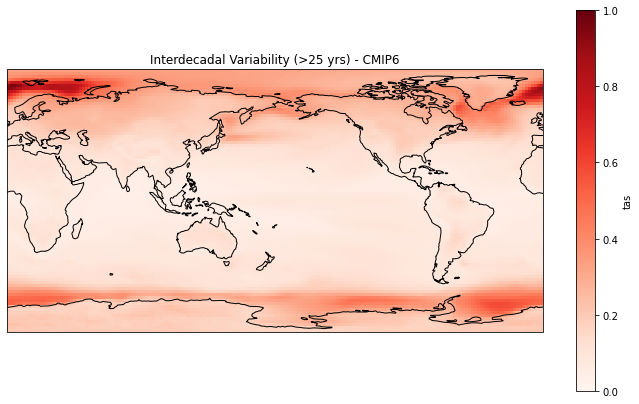

In [59]:
# 20 entries
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_noht.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal Variability (>25 yrs) - CMIP6')

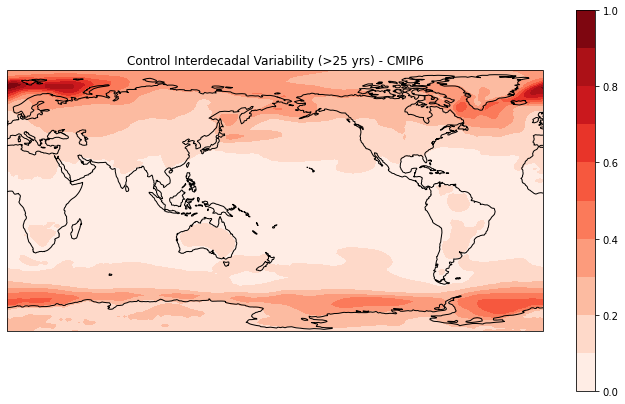

In [28]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, control_noht, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1, levels=10)
ax.coastlines(color='black', linewidth=1)
plt.title('Control Interdecadal Variability (>25 yrs) - CMIP6')
plt.colorbar()

Text(0.5, 1.0, 'Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

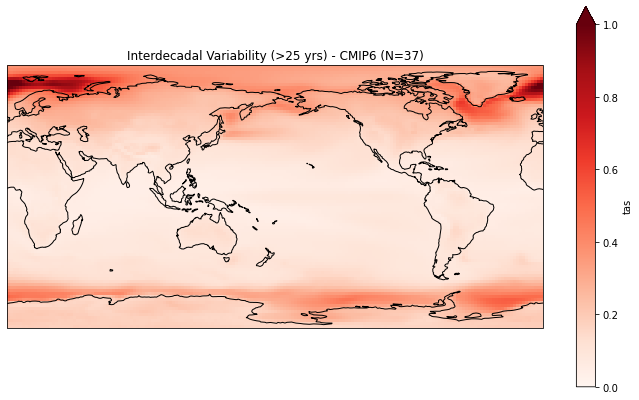

In [20]:
# 37 entries
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_noht.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.title('Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

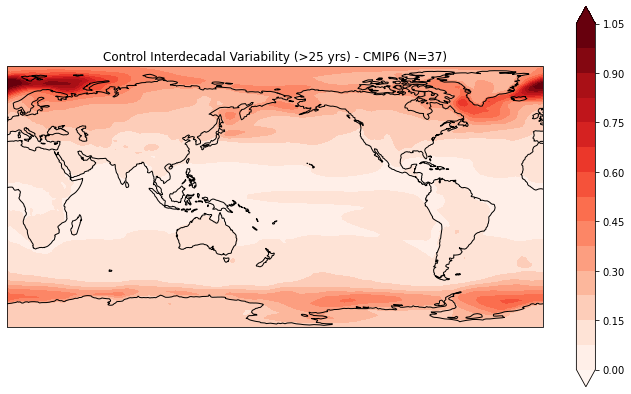

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
levels = [0,0.075,0.15,0.225,0.3,0.375,0.45,0.525,0.6,0.675,0.75,0.825,0.9,0.975,1.05]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, control_noht, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1, levels=levels, extend='both')
ax.coastlines(color='black', linewidth=1)
plt.title('Control Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

## Historical Data

In [11]:
path_hist = cat.loc[(cat['variable_id']=='tas') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(37)['path'].to_list()
path_hist

['/data/cristi/a/cristi/esm_data/cmip6/ACCESS-CM2/historical/r1i1p1f1/tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/ACCESS-ESM1-5/historical/r10i1p1f1/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-CM-1-1-MR/historical/r1i1p1f1/tas_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185101-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/AWI-ESM-1-1-LR/historical/r1i1p1f1/tas_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-CSM2-MR/historical/r1i1p1f1/tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/BCC-ESM1/historical/r1i1p1f1/tas_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CAMS-CSM1-0/historical/r1i1p1f1/tas_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc',
 '/data/cristi/a/cristi/esm_data/cmip6/CAS-ESM2-0/hist

In [12]:
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

dset_list_hist = []

for file in path_hist:
    name = file.removeprefix('/data/cristi/a/cristi/esm_data/cmip6/')
    print(name)
    ds = xr.open_dataset(file)
    ds_tas_rolling = ds.tas.interp(lat=new_lats,lon=new_lons).rolling(time=300, center=True).mean('time')
    ds_tas = ds_tas_rolling.std('time')
    ds_tas['name'] = name # Creating a new dimension for each ensemble member
    dset_list_hist.append(ds_tas)

ACCESS-CM2/historical/r1i1p1f1/tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc
ACCESS-ESM1-5/historical/r10i1p1f1/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc
AWI-CM-1-1-MR/historical/r1i1p1f1/tas_Amon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185101-201412.nc
AWI-ESM-1-1-LR/historical/r1i1p1f1/tas_Amon_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-CSM2-MR/historical/r1i1p1f1/tas_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc
BCC-ESM1/historical/r1i1p1f1/tas_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc
CAMS-CSM1-0/historical/r1i1p1f1/tas_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_185001-201412.nc
CAS-ESM2-0/historical/r1i1p1f1/tas_Amon_CAS-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-FV2/historical/r1i1p1f1/tas_Amon_CESM2-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM-FV2/historical/r1i1p1f1/tas_Amon_CESM2-WACCM-FV2_historical_r1i1p1f1_gn_185001-201412.nc
CESM2-WACCM/historical/r1i1p1f1/tas_Amon_CESM2-WACCM_histori

In [13]:
hist_ds = xr.concat(dset_list_hist, dim='name',coords='minimal',compat='override')
hist_ds

<xarray.DataArray 'tas' (name: 37, lat: 88, lon: 179)>
array([[[0.40127718, 0.40264204, 0.40308577, ..., 0.38591246,
         0.38900126, 0.39159274],
        [0.35789035, 0.35841349, 0.35863339, ..., 0.3578244 ,
         0.35888006, 0.35868129],
        [0.3593578 , 0.35496526, 0.35035853, ..., 0.36401019,
         0.36365726, 0.3633797 ],
        ...,
        [0.53770973, 0.55026513, 0.56385401, ..., 0.4803343 ,
         0.49387419, 0.50900267],
        [0.46008108, 0.46407017, 0.46832681, ..., 0.44303209,
         0.44561443, 0.44935094],
        [0.39643165, 0.39771919, 0.39908155, ..., 0.39254368,
         0.39277715, 0.39429297]],

       [[0.27561183, 0.2760678 , 0.27639492, ..., 0.27303583,
         0.27365392, 0.27434189],
        [0.27481465, 0.27788059, 0.28022743, ..., 0.25789687,
         0.26215647, 0.26669153],
        [0.25945683, 0.25918691, 0.25924094, ..., 0.25676623,
         0.25836607, 0.25924899],
...
        [0.46706688, 0.47734904, 0.48654114, ..., 0.4047836 ,
         0.42126466, 0.43876599],
        [0.43078612, 0.43679202, 0.44152086, ..., 0.40319759,
         0.41049291, 0.41741797],
        [0.39385021, 0.39645034, 0.39873575, ..., 0.38230005,
         0.38489297, 0.38756402]],

       [[0.33233203, 0.33099387, 0.32971754, ..., 0.33523333,
         0.33460719, 0.33418237],
        [0.34901908, 0.34847948, 0.34714188, ..., 0.34487413,
         0.34642052, 0.34775095],
        [0.36103954, 0.3623951 , 0.363844  , ..., 0.36551096,
         0.36343723, 0.36210064],
        ...,
        [0.31651493, 0.32627761, 0.3375016 , ..., 0.27606802,
         0.28472082, 0.29378304],
        [0.31141757, 0.31858347, 0.32602551, ..., 0.28980387,
         0.29417692, 0.29959879],
        [0.29827893, 0.29995115, 0.30133461, ..., 0.29365414,
         0.29444708, 0.29618548]]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U104 'ACCESS-CM2/historical/r1i1p1f1/tas_Amon_ACCESS-CM2...

In [14]:
hist = hist_ds.mean('name')
hist.load()

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[0.36139967, 0.36602878, 0.36428685, ..., 0.36498952, 0.36342596,
        0.36420318],
       [0.36307435, 0.37054967, 0.3722876 , ..., 0.35715741, 0.35984818,
        0.3631379 ],
       [0.37615007, 0.37906007, 0.37851246, ..., 0.3682918 , 0.36819091,
        0.36871859],
       ...,
       [0.72694529, 0.72352123, 0.73030163, ..., 0.68525739, 0.69172069,
        0.69976337],
       [0.71061905, 0.70141471, 0.70517237, ..., 0.68681021, 0.68887468,
        0.69309038],
       [0.69246121, 0.68079395, 0.68186797, ..., 0.67818171, 0.67904254,
        0.68050098]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Interdecadal Variability (>25 yrs) - CMIP6')

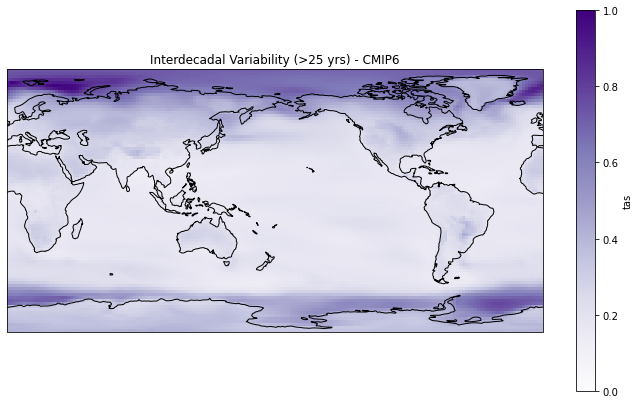

In [9]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hist.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6')

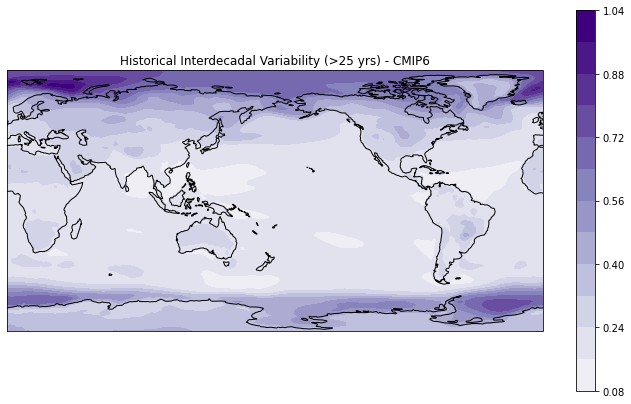

In [31]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(hist.lon,hist.lat, hist, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1, levels=10)
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6')
plt.colorbar()

### N=37

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

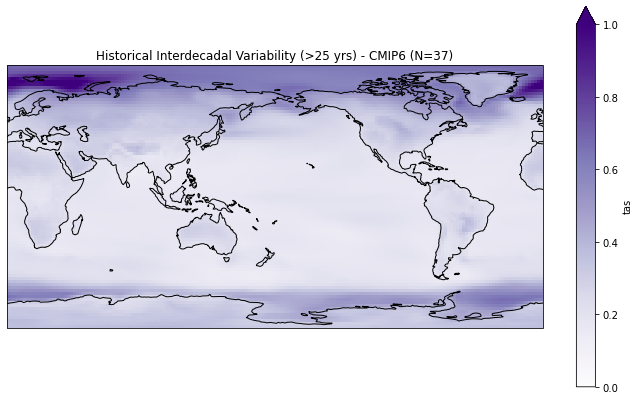

In [15]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hist.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

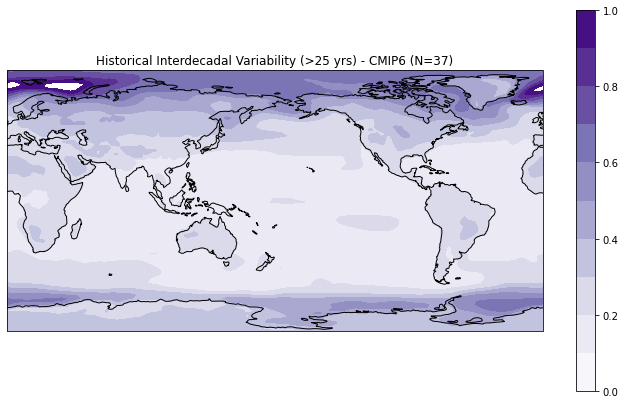

In [43]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(hist.lon,hist.lat, hist, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1, levels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.coastlines(color='black', linewidth=1)
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

## Historical - Control

In [16]:
diff_var = hist - control

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CMIP6')

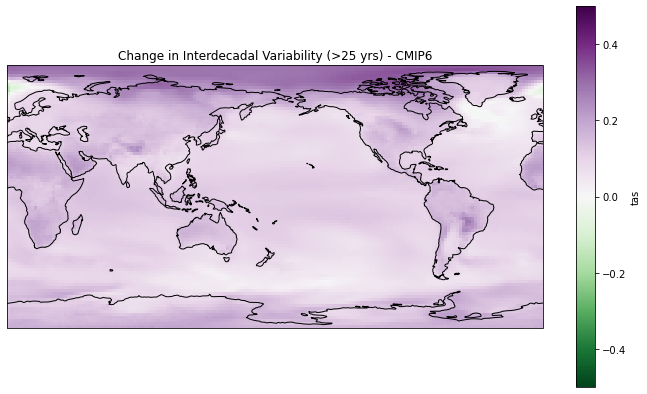

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6')

### N=37

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

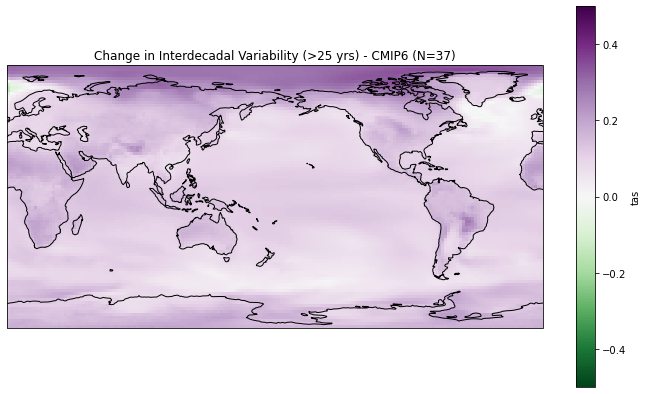

In [19]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

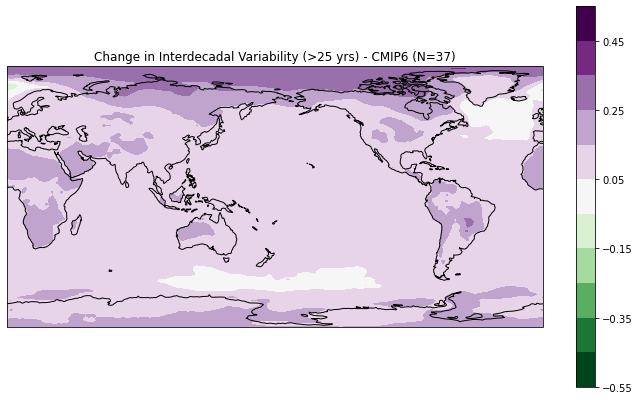

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, diff_var, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5, levels=[-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55])
ax.coastlines(color='black', linewidth=1)
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

## Percentage Change

In [22]:
percent_change = ((diff_var)/control)*100
percent_change

<xarray.DataArray 'tas' (lat: 88, lon: 179)>
array([[89.54692338, 96.82441416, 97.2134846 , ..., 94.33917142,
        90.47204603, 95.31297767],
       [82.2707335 , 87.84299961, 89.62234203, ..., 88.76962782,
        89.83830373, 90.41388145],
       [69.22843363, 78.74255357, 80.35118142, ..., 84.74914262,
        84.11215339, 83.27780648],
       ...,
       [62.35970741, 66.17986889, 64.11156476, ..., 78.40764318,
        75.95286756, 72.75819887],
       [72.13856871, 76.57126508, 74.87816523, ..., 84.02428436,
        82.31234195, 80.48130398],
       [78.92311822, 83.93451677, 83.11809348, ..., 87.27774895,
        86.47740486, 85.82535488]])
Coordinates:
    height   float64 2.0
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6')

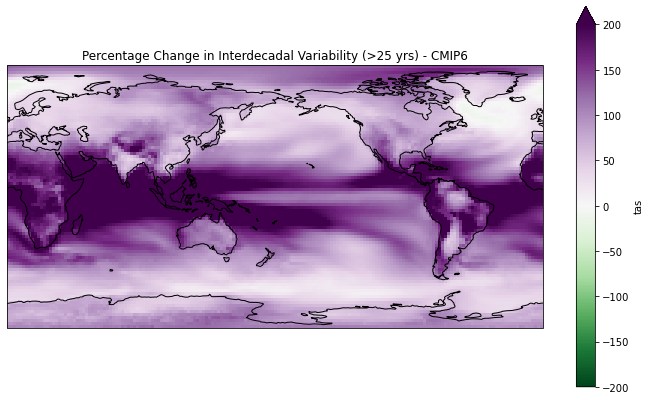

In [58]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_change.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6')

### N=37

Text(0.5, 1.0, 'Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

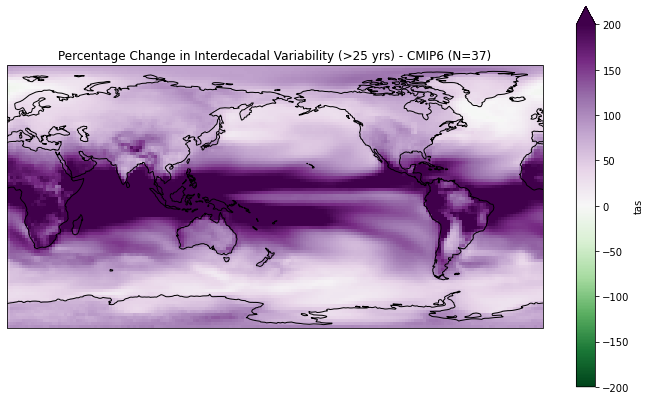

In [33]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_change.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

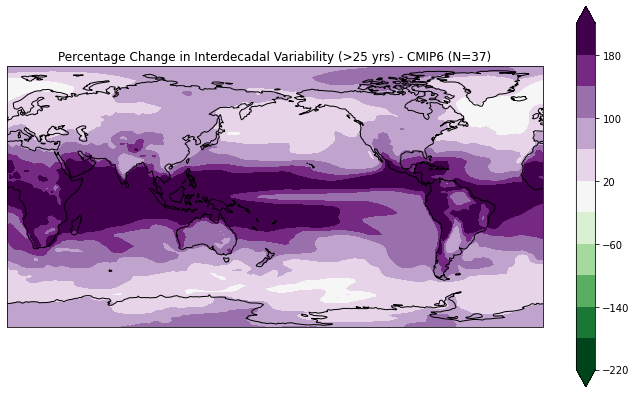

In [24]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, percent_change, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200, levels=[-220,-180,-140,-100,-60,-20,20,60,100,140,180,220],extend='both')
ax.coastlines(color='black', linewidth=1)
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

## Upwards Motion Contours

In [13]:
path_omega = cat.loc[(cat['variable_id']=='wap') &
               (cat['activity_id']=='CMIP') &
               (cat['frequency']=='mon') & 
               (cat['experiment_id'].str.contains('historical'))].drop_duplicates('source_id').head(37)['path'].to_list()
path_omega

[]

In [14]:
# Head to google catalog to get some vertical motion data

# Read in data catalog

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [15]:
# Find omega

df_vert = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'wap' & experiment_id == 'historical'")
df_vert

activity_id       institution_id      source_id experiment_id  \
9914          CMIP            NOAA-GFDL       GFDL-CM4    historical   
22100         CMIP                 IPSL   IPSL-CM6A-LR    historical   
22373         CMIP                 IPSL   IPSL-CM6A-LR    historical   
22543         CMIP                 IPSL   IPSL-CM6A-LR    historical   
22870         CMIP                 IPSL   IPSL-CM6A-LR    historical   
...            ...                  ...            ...           ...   
522926        CMIP                  MRI     MRI-ESM2-0    historical   
522936        CMIP                  MRI     MRI-ESM2-0    historical   
523302        CMIP                  MRI     MRI-ESM2-0    historical   
523733        CMIP                 CMCC   CMCC-CM2-SR5    historical   
523759        CMIP  EC-Earth-Consortium  EC-Earth3-Veg    historical   

        member_id table_id variable_id grid_label  \
9914     r1i1p1f1     Amon         wap        gr1   
22100    r2i1p1f1     Amon         wap         gr   
22373   r30i1p1f1     Amon         wap         gr   
22543    r8i1p1f1     Amon         wap         gr   
22870   r29i1p1f1     Amon         wap         gr   
...           ...      ...         ...        ...   
522926   r8i1p1f1     Amon         wap         gn   
522936   r7i1p1f1     Amon         wap         gn   
523302   r6i1p1f1     Amon         wap         gn   
523733   r2i1p2f1     Amon         wap         gn   
523759   r1i1p1f1     Amon         wap         gr   

                                                   zstore  dcpp_init_year  \
9914    gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...             NaN   
22100   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22373   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22543   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
22870   gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...             NaN   
...                                                   ...             ...   
522926  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
522936  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
523302  gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...             NaN   
523733  gs://cmip6/CMIP6/CMIP/CMCC/CMCC-CM2-SR5/histor...             NaN   
523759  gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...             NaN   

         version  
9914    20180701  
22100   20180803  
22373   20180803  
22543   20180803  
22870   20180803  
...          ...  
522926  20210813  
522936  20210813  
523302  20210907  
523733  20211109  
523759  20211207  

[567 rows x 11 columns]

In [16]:
df_vert = df_vert.drop_duplicates('source_id').head(37)
df_vert

activity_id     institution_id        source_id experiment_id  \
9914          CMIP          NOAA-GFDL         GFDL-CM4    historical   
22100         CMIP               IPSL     IPSL-CM6A-LR    historical   
32398         CMIP          NASA-GISS      GISS-E2-1-G    historical   
37822         CMIP       CNRM-CERFACS       CNRM-CM6-1    historical   
42815         CMIP                BCC      BCC-CSM2-MR    historical   
44150         CMIP       CNRM-CERFACS      CNRM-ESM2-1    historical   
44893         CMIP                BCC         BCC-ESM1    historical   
45485         CMIP                AWI    AWI-CM-1-1-MR    historical   
55997         CMIP               NCAR      CESM2-WACCM    historical   
59851         CMIP               NCAR            CESM2    historical   
59945         CMIP                MRI       MRI-ESM2-0    historical   
64205         CMIP              MIROC           MIROC6    historical   
68161         CMIP                SNU      SAM0-UNICON    historical   
69510         CMIP          NASA-GISS      GISS-E2-1-H    historical   
70714         CMIP               MOHC      UKESM1-0-LL    historical   
79626         CMIP              CCCma          CanESM5    historical   
81591         CMIP              CCCma    CanESM5-CanOE    historical   
206228        CMIP                INM        INM-CM4-8    historical   
206404        CMIP                INM        INM-CM5-0    historical   
209672        CMIP               MOHC  HadGEM3-GC31-LL    historical   
210991        CMIP  HAMMOZ-Consortium  MPI-ESM-1-2-HAM    historical   
212755        CMIP              NUIST            NESM3    historical   
217499        CMIP               CAMS      CAMS-CSM1-0    historical   
222118        CMIP              MPI-M    MPI-ESM1-2-LR    historical   
222684        CMIP              MPI-M    MPI-ESM1-2-HR    historical   
244728        CMIP          NOAA-GFDL        GFDL-ESM4    historical   
252933        CMIP          NASA-GISS   GISS-E2-1-G-CC    historical   
254279        CMIP                NCC       NorESM2-LM    historical   
254874        CMIP                CAS        FGOALS-g3    historical   
276659        CMIP              MIROC       MIROC-ES2L    historical   
288613        CMIP                NCC          NorCPM1    historical   
295939        CMIP                CAS      FGOALS-f3-L    historical   
375819        CMIP       CNRM-CERFACS    CNRM-CM6-1-HR    historical   
376435        CMIP           NIMS-KMA       KACE-1-0-G    historical   
378944        CMIP       CSIRO-ARCCSS       ACCESS-CM2    historical   
380146        CMIP                NCC       NorESM2-MM    historical   
383163        CMIP              CSIRO    ACCESS-ESM1-5    historical   

        member_id table_id variable_id grid_label  \
9914     r1i1p1f1     Amon         wap        gr1   
22100    r2i1p1f1     Amon         wap         gr   
32398    r2i1p1f1     Amon         wap         gn   
37822    r1i1p1f2     Amon         wap         gr   
42815    r2i1p1f1     Amon         wap         gn   
44150    r1i1p1f2     Amon         wap         gr   
44893    r2i1p1f1     Amon         wap         gn   
45485    r3i1p1f1     Amon         wap         gn   
55997    r2i1p1f1     Amon         wap         gn   
59851    r1i1p1f1     Amon         wap         gn   
59945    r5i1p1f1     Amon         wap         gn   
64205    r7i1p1f1     Amon         wap         gn   
68161    r1i1p1f1     Amon         wap         gn   
69510    r1i1p1f1     Amon         wap         gn   
70714    r1i1p1f2     Amon         wap         gn   
79626   r11i1p1f1     Amon         wap         gn   
81591    r1i1p2f1     Amon         wap         gn   
206228   r1i1p1f1     Amon         wap        gr1   
206404   r1i1p1f1     Amon         wap        gr1   
209672   r4i1p1f3     Amon         wap         gn   
210991   r1i1p1f1     Amon         wap         gn   
212755   r2i1p1f1     Amon         wap         gn   
217499   r1i1p1f1     Amon         wap         gn  

In [16]:
# View one dataset

gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_vert.zstore.values[1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, plev: 19, time: 1980, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev         (plev) float32 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    wap          (time, plev, lat, lon) float32 dask.array<chunksize=(40, 19, 143, 144), meta=np.ndarray>
Attributes: (12/54)
    CMIP6_CV_version:       cv=6.2.3.5-2-g63b123e
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  historical
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    tracking_id:            hdl:21.14100/0653fa7d-815b-4bb7-8c59-af0b32943a03
    variable_id:            wap
    variant_info:           Restart from another point in piControl.. Informa...
    variant_label:          r2i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/0653fa7d-815b-4bb7-8c59-af0b32943a03
    version_id:             v20180803

In [17]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)

#time index to assign model times to
new_time_index=pd.date_range(start='1851-01-01',freq='M',periods=2988)
    
dset_list_wap = []
for zstore in df_vert.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds = ds.wap.interp(lat=new_lats,lon=new_lons)
    ds = ds.sel(time=slice('1976','2006'))
    ds = ds.sel(plev=50000, method='nearest')
    ds = ds.mean('time')
    #print(dict(ds.dims))
    ds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_wap.append(ds)

CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Amon.wap.gr1.v20180701
CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Amon.wap.gr.v20180803
CMIP.NASA-GISS.GISS-E2-1-G.historical.r2i1p1f1.Amon.wap.gn.v20180827
CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.r1i1p1f2.Amon.wap.gr.v20180917
CMIP.BCC.BCC-CSM2-MR.historical.r2i1p1f1.Amon.wap.gn.v20181115
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Amon.wap.gr.v20181206
CMIP.BCC.BCC-ESM1.historical.r2i1p1f1.Amon.wap.gn.v20181217
CMIP.AWI.AWI-CM-1-1-MR.historical.r3i1p1f1.Amon.wap.gn.v20181218
CMIP.NCAR.CESM2-WACCM.historical.r2i1p1f1.Amon.wap.gn.v20190227
CMIP.NCAR.CESM2.historical.r1i1p1f1.Amon.wap.gn.v20190308
CMIP.MRI.MRI-ESM2-0.historical.r5i1p1f1.Amon.wap.gn.v20190308
CMIP.MIROC.MIROC6.historical.r7i1p1f1.Amon.wap.gn.v20190311
CMIP.SNU.SAM0-UNICON.historical.r1i1p1f1.Amon.wap.gn.v20190323
CMIP.NASA-GISS.GISS-E2-1-H.historical.r1i1p1f1.Amon.wap.gn.v20190403
CMIP.MOHC.UKESM1-0-LL.historical.r1i1p1f2.Amon.wap.gn.v20190406
CMIP.CCCma.CanESM5.historica

In [18]:
#Make into an array
vert_ds = xr.concat(dset_list_wap, dim='name', coords='minimal', compat='override')
vert_ds

<xarray.DataArray 'wap' (name: 37, lat: 88, lon: 179)>
dask.array<concatenate, shape=(37, 88, 179), dtype=float32, chunksize=(1, 88, 179), chunktype=numpy.ndarray>
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U80 'CMIP.NOAA-GFDL.GFDL-CM4.historical.r1i1p1f1.Amon.wa...

In [19]:
vert_ds = vert_ds.mean('name')
vert_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 9.05317347e-03,  5.35726221e-03,  3.90954921e-03, ...,
         1.37608778e-02,  1.27784014e-02,  1.16651980e-02],
       [ 1.62603296e-02,  1.84076093e-02,  1.68463495e-02, ...,
         2.34749150e-02,  2.32172329e-02,  2.24996507e-02],
       [ 1.72343142e-02,  1.73817184e-02,  1.67526975e-02, ...,
         1.50780585e-02,  1.46754114e-02,  1.46230198e-02],
       ...,
       [-2.22924957e-03, -1.80104235e-03, -1.62051118e-03, ...,
        -1.75005000e-03, -2.10483326e-03, -2.04990618e-03],
       [-6.93217677e-04, -1.27934688e-03, -1.30213355e-03, ...,
        -7.43095938e-04, -8.93206510e-04, -9.83634265e-04],
       [ 4.50923544e-04, -8.85086847e-05,  6.49775393e-05, ...,
        -5.63950336e-04, -4.56162205e-04, -3.77876189e-04]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

Text(0.5, 1.0, 'Vertical Motion at 500 mb (N=37)')

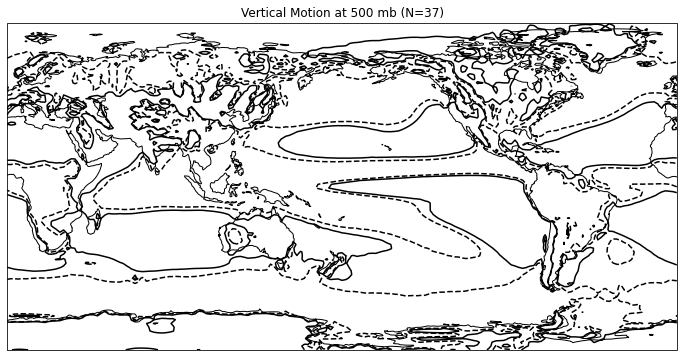

In [45]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='black', levels=[-0.005,0.005])
ax.coastlines(color='black', linewidth=1)
plt.title('Vertical Motion at 500 mb (N=37)')

## All plots with contours

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CMIP6')

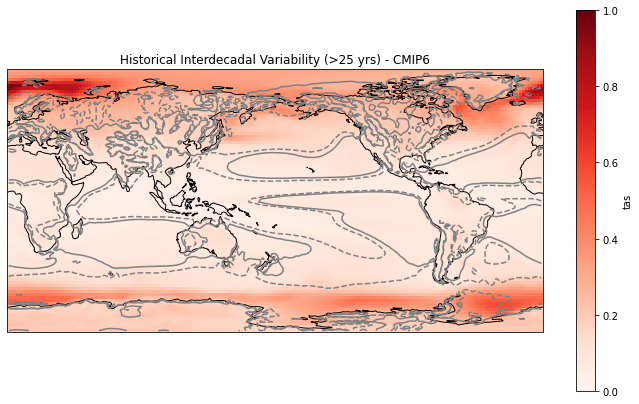

In [50]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_noht.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6')

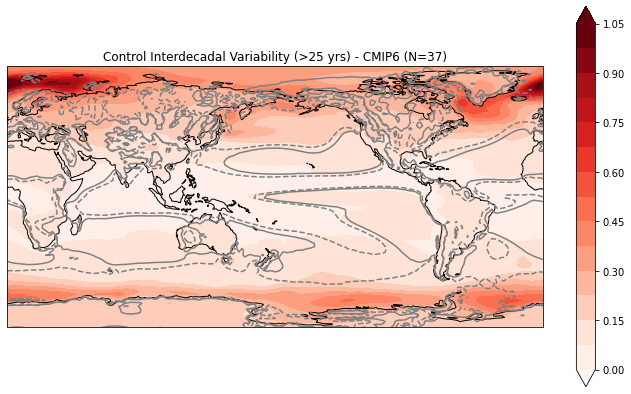

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
levels = [0,0.075,0.15,0.225,0.3,0.375,0.45,0.525,0.6,0.675,0.75,0.825,0.9,0.975,1.05]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, control_noht, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1, levels=levels, extend='both')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Control Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CMIP6')

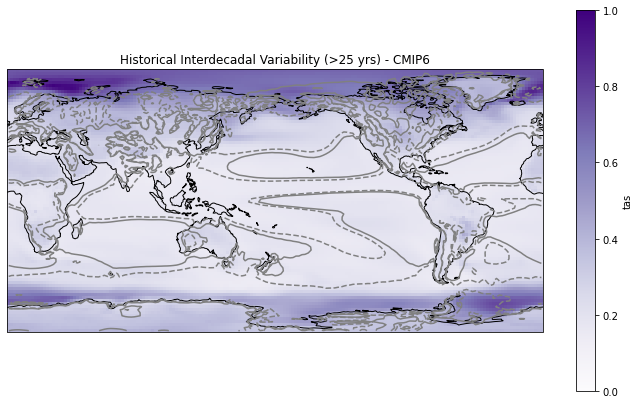

In [51]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hist.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6')

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CMIP6')

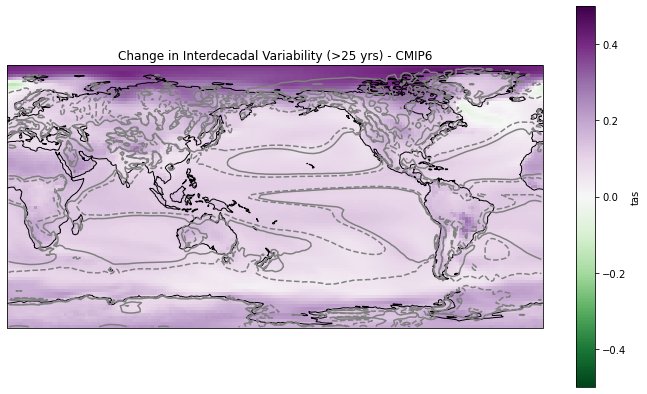

In [55]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6')

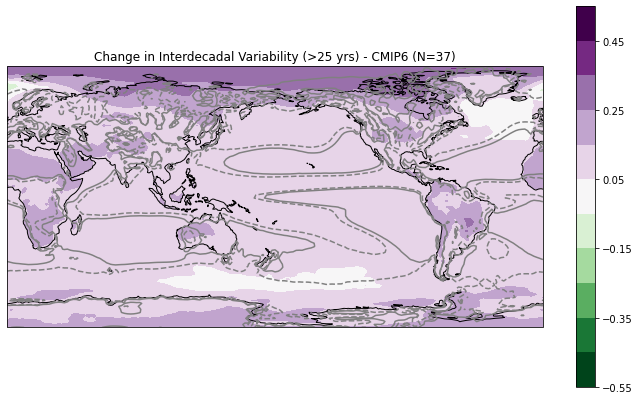

In [34]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, diff_var, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5, levels=[-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55])
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

Text(0.5, 1.0, 'Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6')

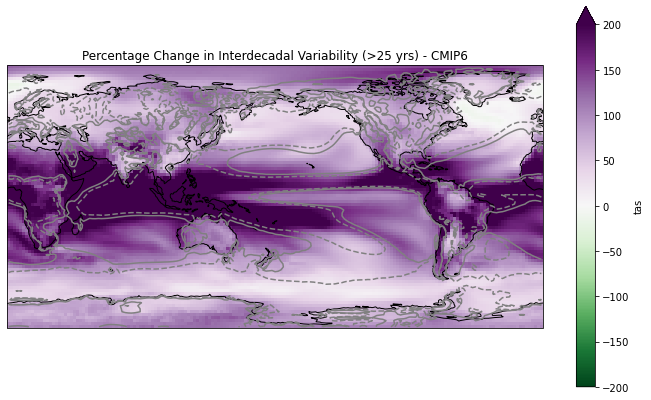

In [57]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_change.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6')

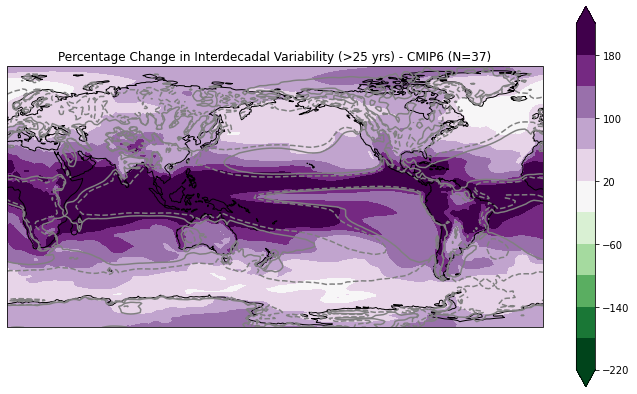

In [33]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
plt.contourf(control_noht.lon,control_noht.lat, percent_change, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200, levels=[-220,-180,-140,-100,-60,-20,20,60,100,140,180,220],extend='both')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')
plt.colorbar()

### N=37

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

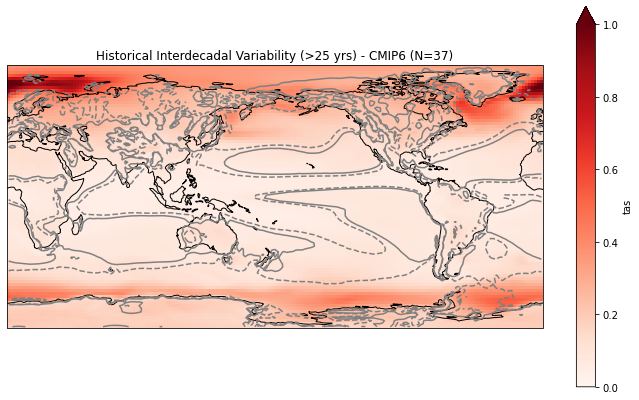

In [46]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
control_noht.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

Text(0.5, 1.0, 'Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

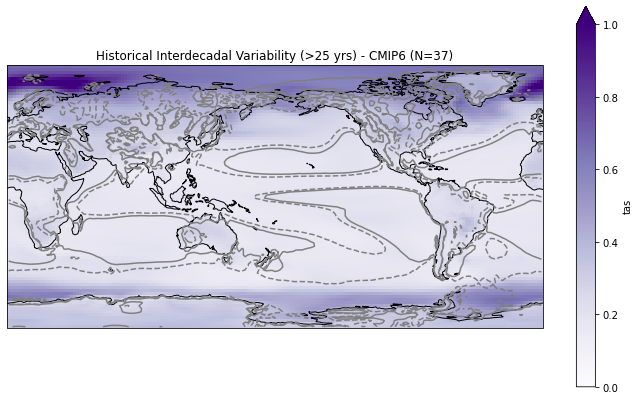

In [50]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
hist.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Purples', vmin=0, vmax=1)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Historical Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

Text(0.5, 1.0, 'Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

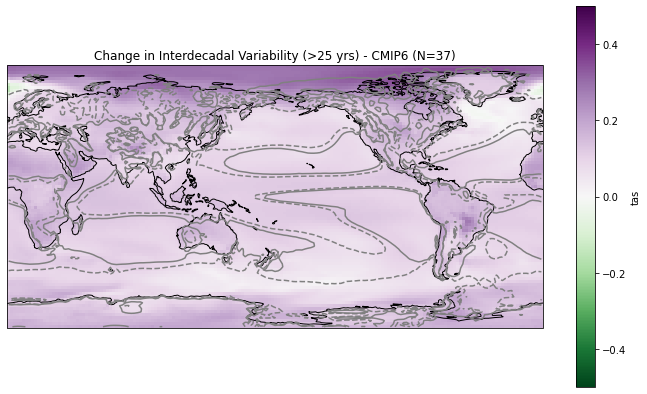

In [55]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
diff_var.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-0.5, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

Text(0.5, 1.0, 'Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

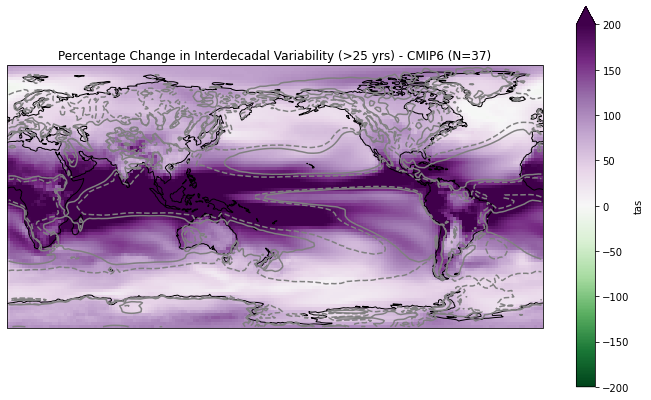

In [56]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
percent_change.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='PRGn_r', vmin=-200, vmax=200)
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Percentage Change in Interdecadal Variability (>25 yrs) - CMIP6 (N=37)')

## Load in piControl wap data

In [58]:
# Find omega

df_vert_cont = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'wap' & experiment_id == 'piControl'").drop_duplicates('source_id').head(37)
df_vert_cont

activity_id institution_id        source_id experiment_id member_id  \
9413          CMIP      NOAA-GFDL         GFDL-CM4     piControl  r1i1p1f1   
16718         CMIP      NOAA-GFDL        GFDL-ESM4     piControl  r1i1p1f1   
31886         CMIP   CNRM-CERFACS       CNRM-CM6-1     piControl  r1i1p1f2   
32200         CMIP      NASA-GISS      GISS-E2-1-G     piControl  r1i1p1f1   
40424         CMIP            BCC      BCC-CSM2-MR     piControl  r1i1p1f1   
42735         CMIP   CNRM-CERFACS      CNRM-ESM2-1     piControl  r1i1p1f2   
44913         CMIP            BCC         BCC-ESM1     piControl  r1i1p1f1   
45702         CMIP            AWI    AWI-CM-1-1-MR     piControl  r1i1p1f1   
60172         CMIP            MRI       MRI-ESM2-0     piControl  r1i1p1f1   
65322         CMIP          MIROC           MIROC6     piControl  r1i1p1f1   
66932         CMIP           IPSL     IPSL-CM6A-LR     piControl  r1i2p1f1   
67591         CMIP           NCAR            CESM2     piControl  r1i1p1f1   
67662         CMIP           NCAR      CESM2-WACCM     piControl  r1i1p1f1   
75743         CMIP      NASA-GISS      GISS-E2-1-H     piControl  r1i1p1f1   
87894         CMIP          CCCma    CanESM5-CanOE     piControl  r1i1p2f1   
90069         CMIP          CCCma          CanESM5     piControl  r1i1p1f1   
206110        CMIP            INM        INM-CM4-8     piControl  r1i1p1f1   
209065        CMIP            INM        INM-CM5-0     piControl  r1i1p1f1   
217979        CMIP          NUIST            NESM3     piControl  r1i1p1f1   
236037        CMIP          MPI-M    MPI-ESM1-2-LR     piControl  r1i1p1f1   
237778        CMIP          MPI-M    MPI-ESM1-2-HR     piControl  r1i1p1f1   
245703        CMIP           CAMS      CAMS-CSM1-0     piControl  r1i1p1f1   
253870        CMIP      NASA-GISS   GISS-E2-1-G-CC     piControl  r1i1p1f1   
254982        CMIP            CAS        FGOALS-g3     piControl  r1i1p1f1   
277102        CMIP          MIROC       MIROC-ES2L     piControl  r1i1p1f2   
287698        CMIP            SNU      SAM0-UNICON     piControl  r1i1p1f1   
288577        CMIP            NCC          NorCPM1     piControl  r3i1p1f1   
294901        CMIP            NCC        NorESM1-F     piControl  r1i1p1f1   
376188        CMIP   CNRM-CERFACS    CNRM-CM6-1-HR     piControl  r1i1p1f2   
376503        CMIP            CAS      FGOALS-f3-L     piControl  r1i1p1f1   
381521        CMIP            NCC       NorESM2-MM     piControl  r1i1p1f1   
381967        CMIP   CSIRO-ARCCSS       ACCESS-CM2     piControl  r1i1p1f1   
384489        CMIP      CCCR-IITM         IITM-ESM     piControl  r1i1p1f1   
384604        CMIP           NCAR  CESM2-WACCM-FV2     piControl  r1i1p1f1   
385520        CMIP      NASA-GISS      GISS-E2-2-G     piControl  r1i1p1f1   
385539        CMIP      NASA-GISS      GISS-E2-2-H     piControl  r1i1p1f1   
385788        CMIP           NCAR        CESM2-FV2     piControl  r1i1p1f1   

       table_id variable_id grid_label  \
9413       Amon         wap        gr1   
16718      Amon         wap        gr1   
31886      Amon         wap         gr   
32200      Amon         wap         gn   
40424      Amon         wap         gn   
42735      Amon         wap         gr   
44913      Amon         wap         gn   
45702      Amon         wap         gn   
60172      Amon         wap         gn   
65322      Amon         wap         gn   
66932      Amon         wap         gr   
67591      Amon         wap         gn   
67662      Amon         wap         gn   
75743      Amon         wap         gn   
87894      Amon         wap         gn   
90069      Amon         wap         gn   
206110     Amon         wap        gr1   
209065     Amon         wap        gr1   
217979     Amon         wap         gn   
236037     Amon         wap         gn   
237778     Amon         wap         gn   
245703     Amon         wap         gn   
253870     Amon         wap         gn   
254982     Amon         wap       

In [59]:
#this only needs to be created once
# From Ryan Abernathy's tutorial - Way 2
gcs = gcsfs.GCSFileSystem(token='anon')
fs = gcsfs.GCSFileSystem(token='anon', access='read_only')

# Regridding
new_lats=np.arange(-87,88,2)
new_lons=np.arange(1,359,2)
    
dset_list_wap_cont = []
for zstore in df_vert_cont.zstore.unique():
    # make a nice concise name from the zstore value
    name = zstore.split('gs://cmip6/CMIP6/')[1].replace('/','.')[:-1]
    print(name)
    ds = xr.open_zarr(fs.get_mapper(zstore),consolidated=True)
    ds = ds.wap.interp(lat=new_lats,lon=new_lons)
    ds = ds.isel(time=slice(200,1400))
    ds = ds.sel(plev=50000, method='nearest')
    ds = ds.mean('time')
    #print(dict(ds.dims))
    ds['name'] = name # Creating a new dimension for each ensemble member
    dset_list_wap_cont.append(ds)

CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Amon.wap.gr1.v20180701
CMIP.NOAA-GFDL.GFDL-ESM4.piControl.r1i1p1f1.Amon.wap.gr1.v20180701
CMIP.CNRM-CERFACS.CNRM-CM6-1.piControl.r1i1p1f2.Amon.wap.gr.v20180814
CMIP.NASA-GISS.GISS-E2-1-G.piControl.r1i1p1f1.Amon.wap.gn.v20180824
CMIP.BCC.BCC-CSM2-MR.piControl.r1i1p1f1.Amon.wap.gn.v20181016
CMIP.CNRM-CERFACS.CNRM-ESM2-1.piControl.r1i1p1f2.Amon.wap.gr.v20181115
CMIP.BCC.BCC-ESM1.piControl.r1i1p1f1.Amon.wap.gn.v20181217
CMIP.AWI.AWI-CM-1-1-MR.piControl.r1i1p1f1.Amon.wap.gn.v20181218


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CMIP.MRI.MRI-ESM2-0.piControl.r1i1p1f1.Amon.wap.gn.v20190308
CMIP.MIROC.MIROC6.piControl.r1i1p1f1.Amon.wap.gn.v20190311


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CMIP.IPSL.IPSL-CM6A-LR.piControl.r1i2p1f1.Amon.wap.gr.v20190319
CMIP.NCAR.CESM2.piControl.r1i1p1f1.Amon.wap.gn.v20190320
CMIP.NCAR.CESM2-WACCM.piControl.r1i1p1f1.Amon.wap.gn.v20190320
CMIP.NASA-GISS.GISS-E2-1-H.piControl.r1i1p1f1.Amon.wap.gn.v20190410
CMIP.CCCma.CanESM5-CanOE.piControl.r1i1p2f1.Amon.wap.gn.v20190429
CMIP.CCCma.CanESM5.piControl.r1i1p1f1.Amon.wap.gn.v20190429
CMIP.INM.INM-CM4-8.piControl.r1i1p1f1.Amon.wap.gr1.v20190605
CMIP.INM.INM-CM5-0.piControl.r1i1p1f1.Amon.wap.gr1.v20190619
CMIP.NUIST.NESM3.piControl.r1i1p1f1.Amon.wap.gn.v20190708


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CMIP.MPI-M.MPI-ESM1-2-LR.piControl.r1i1p1f1.Amon.wap.gn.v20190710


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CMIP.MPI-M.MPI-ESM1-2-HR.piControl.r1i1p1f1.Amon.wap.gn.v20190710


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CMIP.CAMS.CAMS-CSM1-0.piControl.r1i1p1f1.Amon.wap.gn.v20190729
CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.r1i1p1f1.Amon.wap.gn.v20190815
CMIP.CAS.FGOALS-g3.piControl.r1i1p1f1.Amon.wap.gn.v20190818
CMIP.MIROC.MIROC-ES2L.piControl.r1i1p1f2.Amon.wap.gn.v20190823


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dty

CMIP.SNU.SAM0-UNICON.piControl.r1i1p1f1.Amon.wap.gn.v20190910
CMIP.NCC.NorCPM1.piControl.r3i1p1f1.Amon.wap.gn.v20190914
CMIP.NCC.NorESM1-F.piControl.r1i1p1f1.Amon.wap.gn.v20190920
CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.piControl.r1i1p1f2.Amon.wap.gr.v20191021
CMIP.CAS.FGOALS-f3-L.piControl.r1i1p1f1.Amon.wap.gr.v20191029
CMIP.NCC.NorESM2-MM.piControl.r1i1p1f1.Amon.wap.gn.v20191108
CMIP.CSIRO-ARCCSS.ACCESS-CM2.piControl.r1i1p1f1.Amon.wap.gn.v20191112


/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:688: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/coding/times.py:150: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/data/keeling/a/mailes2/miniconda3/envs/paleoproj/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 ob

CMIP.CCCR-IITM.IITM-ESM.piControl.r1i1p1f1.Amon.wap.gn.v20191120
CMIP.NCAR.CESM2-WACCM-FV2.piControl.r1i1p1f1.Amon.wap.gn.v20191120
CMIP.NASA-GISS.GISS-E2-2-G.piControl.r1i1p1f1.Amon.wap.gn.v20191120
CMIP.NASA-GISS.GISS-E2-2-H.piControl.r1i1p1f1.Amon.wap.gn.v20191120
CMIP.NCAR.CESM2-FV2.piControl.r1i1p1f1.Amon.wap.gn.v20191120


In [60]:
#Make into an array
vertcont_ds = xr.concat(dset_list_wap_cont, dim='name', coords='minimal', compat='override')
vertcont_ds

<xarray.DataArray 'wap' (name: 37, lat: 88, lon: 179)>
dask.array<concatenate, shape=(37, 88, 179), dtype=float32, chunksize=(1, 88, 179), chunktype=numpy.ndarray>
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) <U72 'CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Amon.wap...

In [61]:
vertcont_ds = vertcont_ds.mean('name')
vertcont_ds.load()

<xarray.DataArray 'wap' (lat: 88, lon: 179)>
array([[ 0.00886884,  0.0035866 ,  0.00187401, ...,  0.01251455,
         0.01187383,  0.01116023],
       [ 0.01581052,  0.01966359,  0.01786552, ...,  0.02390223,
         0.02407498,  0.02375307],
       [ 0.01608062,  0.01633827,  0.01587763, ...,  0.01222788,
         0.01179263,  0.01169182],
       ...,
       [-0.00157886, -0.00132902, -0.00119198, ..., -0.00140179,
        -0.00172162, -0.00161796],
       [-0.00050992, -0.00144006, -0.00150066, ..., -0.00084193,
        -0.00099983, -0.00111415],
       [ 0.00020973, -0.00080235, -0.0006107 , ..., -0.00139463,
        -0.00124518, -0.00115765]], dtype=float32)
Coordinates:
    plev     float64 5e+04
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357

## Scatter Plot

In [62]:
colored_lats = []
for latitude in vert_ds['lat'].values:
    for i in range(179): #length of longitude
       colored_lats.append(latitude)
print(len(colored_lats))

15752


In [63]:
diff_omega = vert_ds - vertcont_ds
diff_var = hist - control
percent_change = ((diff_var)/control)*100
percent_omega = ((diff_omega)/vertcont_ds)*100

In [64]:
# Picking out only central latitudes
central_lats_hist = hist.sel(lat=slice(-40,40))
central_lats_cont = control.sel(lat=slice(-40,40))
central_lats_diff = diff_var.sel(lat=slice(-40,40))
central_lats_perc = percent_change.sel(lat=slice(-40,40))

central_vert_hist = vert_ds.sel(lat=slice(-40,40))
central_vert_cont = vertcont_ds.sel(lat=slice(-40,40))
central_vert_diff = diff_omega.sel(lat=slice(-40,40))
central_vert_perc = percent_omega.sel(lat=slice(-40,40))

In [65]:
colored_cen_lats = []
for latitude in central_lats_hist['lat'].values:
    for i in range(179): #length of longitude
       colored_cen_lats.append(latitude)
print(len(colored_cen_lats))

7160


Text(0, 0.5, 'Variability')

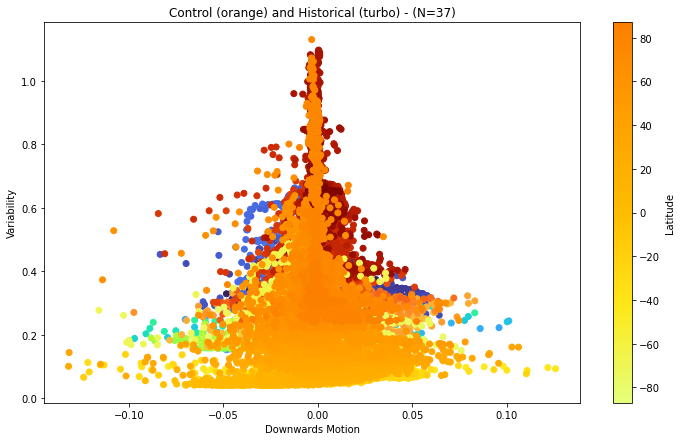

In [76]:
plt.scatter(vert_ds,hist,c=colored_lats,cmap='turbo')
plt.scatter(vertcont_ds,control,c=colored_lats,cmap='Wistia')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Control (orange) and Historical (turbo) - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylabel('Variability')

Text(0, 0.5, 'Variability')

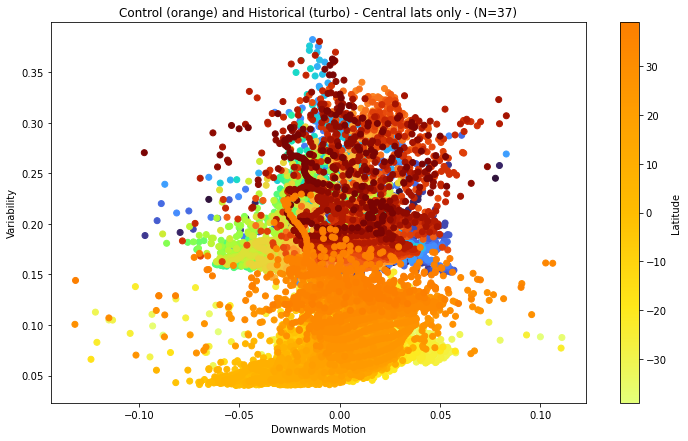

In [77]:
plt.scatter(central_vert_hist,central_lats_hist,c=colored_cen_lats,cmap='turbo')
plt.scatter(central_vert_cont,central_lats_cont,c=colored_cen_lats,cmap='Wistia')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Control (orange) and Historical (turbo) - Central lats only - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylabel('Variability')

Text(0.5, 1.0, 'Control')

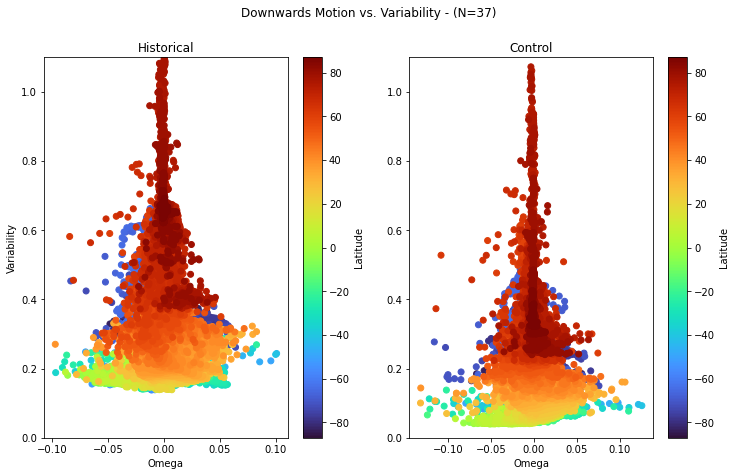

In [78]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.suptitle('Downwards Motion vs. Variability - (N=37)')
plt.subplot(1,2,1)
plt.scatter(vert_ds,hist,c=colored_lats,cmap='turbo')
plt.ylim(0,1.1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.ylabel('Variability')
plt.xlabel('Omega')
plt.title('Historical')
plt.subplot(1,2,2)
plt.scatter(vertcont_ds,control,c=colored_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.ylim(0,1.1)
plt.xlabel('Omega')
plt.title('Control')

Text(0.5, 1.0, 'Control')

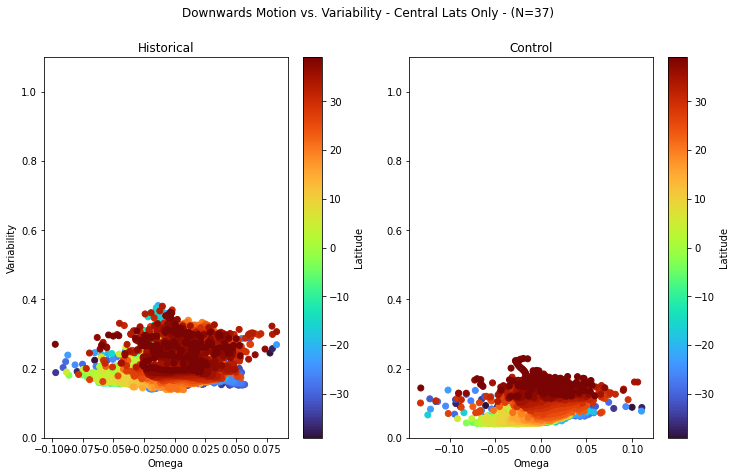

In [79]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.suptitle('Downwards Motion vs. Variability - Central Lats Only - (N=37)')
plt.subplot(1,2,1)
plt.scatter(central_vert_hist,central_lats_hist,c=colored_cen_lats,cmap='turbo')
plt.ylim(0,1.1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.ylabel('Variability')
plt.xlabel('Omega')
plt.title('Historical')
plt.subplot(1,2,2)
plt.scatter(central_vert_cont,central_lats_cont,c=colored_cen_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.ylim(0,1.1)
plt.xlabel('Omega')
plt.title('Control')

Text(0, 0.5, 'Variability Change')

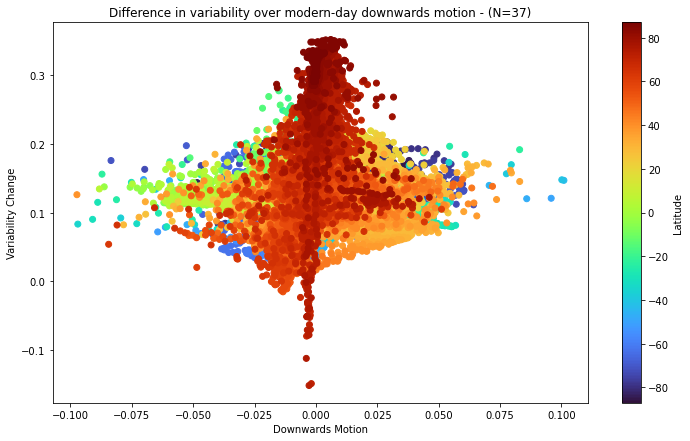

In [80]:
plt.scatter(vert_ds, diff_var, c=colored_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Difference in variability over modern-day downwards motion - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylabel('Variability Change')

Text(0, 0.5, 'Variability Change')

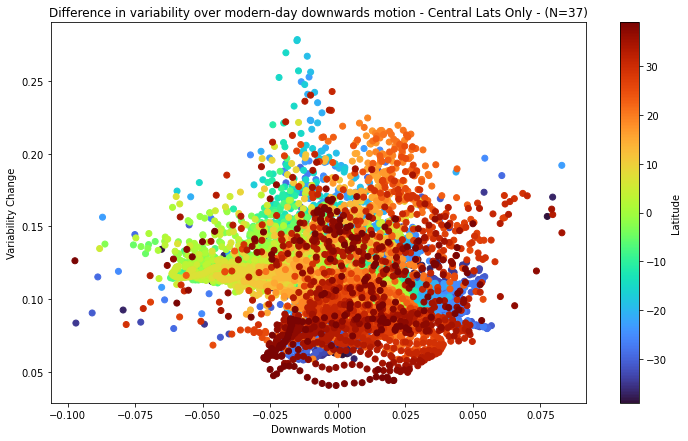

In [81]:
plt.scatter(central_vert_hist, central_lats_diff, c=colored_cen_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Difference in variability over modern-day downwards motion - Central Lats Only - (N=37)')
plt.xlabel('Downwards Motion')
plt.ylabel('Variability Change')

Text(0.5, 1.0, 'Difference in upwards motion vs. change in variability from control to historical - (N=37)')

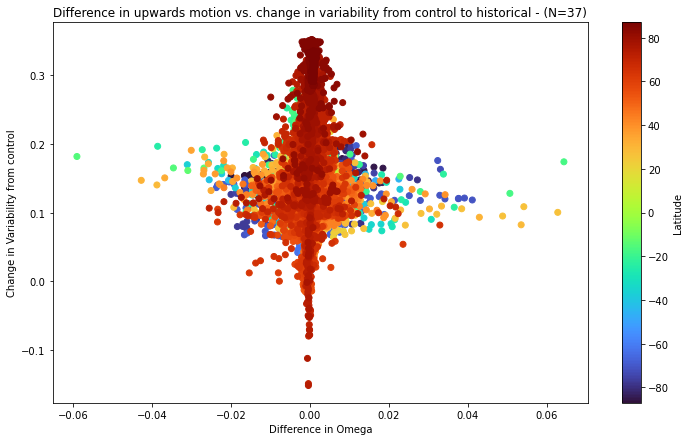

In [82]:
plt.scatter(diff_omega, diff_var, c=colored_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.xlabel('Difference in Omega')
plt.ylabel('Change in Variability from control')
plt.title('Difference in upwards motion vs. change in variability from control to historical - (N=37)')

Text(0.5, 1.0, 'Difference in upwards motion vs. change in variability from control to historical - Central Lats Only - (N=37)')

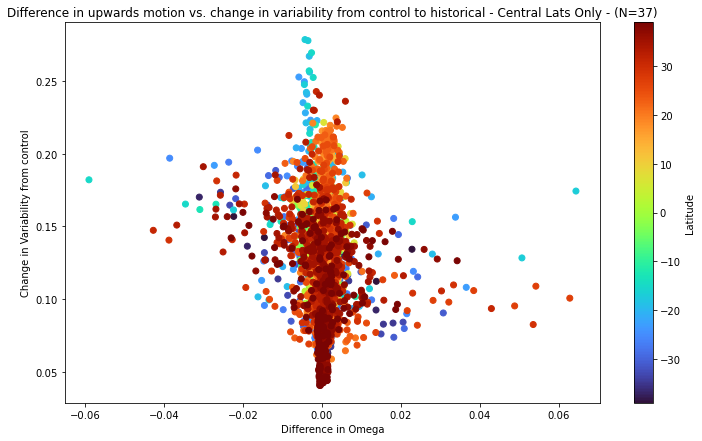

In [83]:
plt.scatter(central_vert_diff, central_lats_diff, c=colored_cen_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.xlabel('Difference in Omega')
plt.ylabel('Change in Variability from control')
plt.title('Difference in upwards motion vs. change in variability from control to historical - Central Lats Only - (N=37)')

Text(0, 0.5, 'Percentage Change in variability')

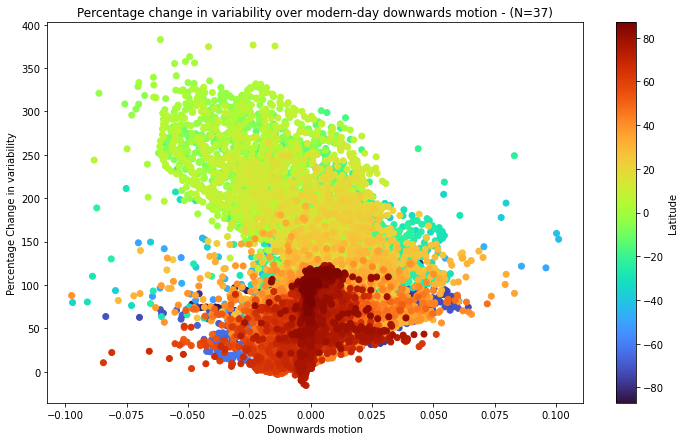

In [84]:
plt.scatter(vert_ds, percent_change, c=colored_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Percentage change in variability over modern-day downwards motion - (N=37)')
plt.xlabel('Downwards motion')
plt.ylabel('Percentage Change in variability')

Text(0, 0.5, 'Percentage Change in variability')

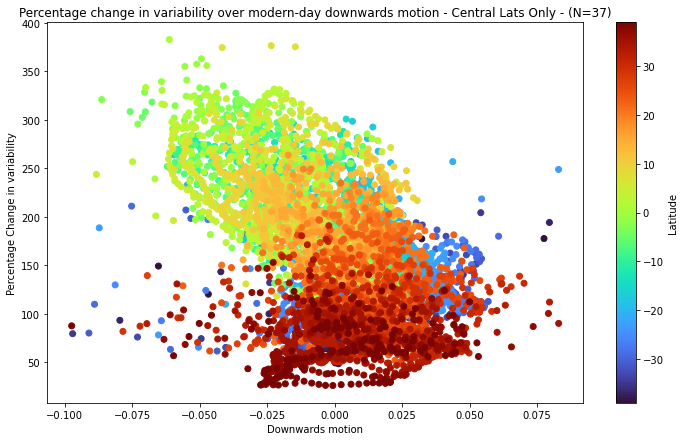

In [85]:
plt.scatter(central_vert_hist, central_lats_perc, c=colored_cen_lats,cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Latitude')
plt.title('Percentage change in variability over modern-day downwards motion - Central Lats Only - (N=37)')
plt.xlabel('Downwards motion')
plt.ylabel('Percentage Change in variability')